C:\Users\User\AppData\Local\Temp\ipykernel_9332\2705817979.py:119: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['signal'].iat[i] = -1
C:\Users\User\AppData\Local\Temp\ipykernel_9332\2705817979.py:120: FutureWarning: ChainedAssignmentErro

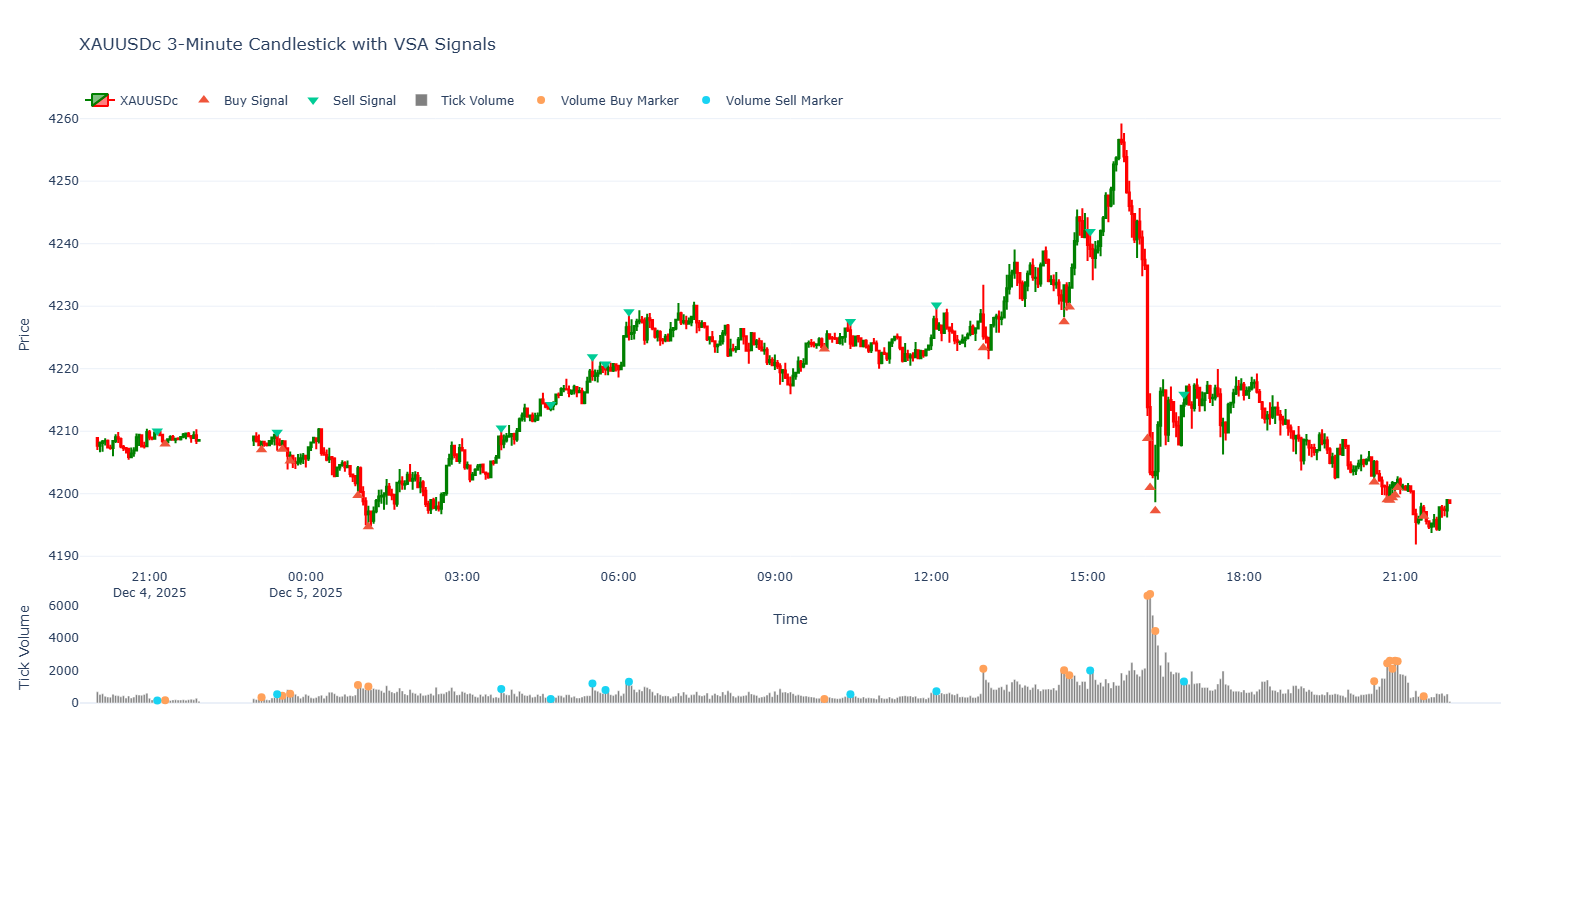

Recent VSA signals (most recent first):
2025-12-05 21:27 | Signal: BUY | Vol: 418 | Reason: No Supply (low vol narrow down bar after decline) -> probable test, buy
2025-12-05 20:57 | Signal: BUY | Vol: 2563 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 20:54 | Signal: BUY | Vol: 2601 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 20:51 | Signal: BUY | Vol: 2104 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 20:48 | Signal: BUY | Vol: 2596 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 20:45 | Signal: BUY | Vol: 2435 | Reason: Climax Down (high vol & large down bar) -> possible selling exhaustion
2025-12-05 20:30 | Signal: BUY | Vol: 1332 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 16:51 | Signal: SELL | Vol: 1316 | Reason: No Demand (low vol narrow up bar after advance) -> probable weak continuation
2025-12-05 16:18 | Signal: BUY | Vol: 4421 | Reason: High vol up after downtrend -> s

In [1]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Feature engineering for VSA
# -------------------------
# basic bar measurements
df['range'] = df['high'] - df['low']
df['body'] = (df['close'] - df['open']).abs()
df['upper_wick'] = df['high'] - df[['open', 'close']].max(axis=1)
df['lower_wick'] = df[['open', 'close']].min(axis=1) - df['low']
df['direction'] = np.where(df['close'] > df['open'], 1, np.where(df['close'] < df['open'], -1, 0))

# rolling stats
vol_ma_len = 20
df['vol_ma'] = df['tick_volume'].rolling(vol_ma_len, min_periods=1).mean()
df['vol_std'] = df['tick_volume'].rolling(vol_ma_len, min_periods=1).std().fillna(0)
df['body_ma'] = df['body'].rolling(vol_ma_len, min_periods=1).mean()
df['range_ma'] = df['range'].rolling(vol_ma_len, min_periods=1).mean()

# normalized measures
df['vol_z'] = (df['tick_volume'] - df['vol_ma']) / (df['vol_std'] + 1e-9)
df['body_pct'] = df['body'] / (df['range_ma'] + 1e-9)

# -------------------------
# 6. VSA signal logic
# -------------------------
# signals: 1 buy signal, -1 sell signal, 0 none
df['signal'] = 0
df['signal_reason'] = ""

# parameters (tweakable)
climax_multiplier = 3.0   # very high volume relative to MA
high_vol_multiplier = 1.5 # moderately high volume
low_vol_multiplier = 0.5  # low volume threshold
small_body_thresh = 0.35  # body percent threshold to call "narrow body"
large_body_thresh = 0.6   # large body relative to range

# helper for trend context: short-term slope of closes
df['close_slope'] = df['close'].diff().rolling(6, min_periods=1).mean()

for i in range(2, len(df)):
    vol = df['tick_volume'].iat[i]
    vol_ma = df['vol_ma'].iat[i]
    direction = df['direction'].iat[i]
    body_pct = df['body_pct'].iat[i]
    upper_wick = df['upper_wick'].iat[i]
    lower_wick = df['lower_wick'].iat[i]
    close = df['close'].iat[i]
    open_ = df['open'].iat[i]
    prev_close = df['close'].iat[i-1]
    slope = df['close_slope'].iat[i-1]  # slope before this bar -> context

    # Safety: skip if nan
    if np.isnan(vol_ma) or vol_ma <= 0:
        continue

    # climactic volume up / down (effort producing strong result)
    if vol > vol_ma * climax_multiplier:
        if direction == 1 and body_pct > large_body_thresh:
            # climactic up: supply may be entering (potential reversal)
            df['signal'].iat[i] = -1
            df['signal_reason'].iat[i] = "Climax Up (high vol & large up bar) -> possible distribution"
            continue
        if direction == -1 and body_pct > large_body_thresh:
            # climactic down: selling climax -> possible exhaustion -> buy on test
            df['signal'].iat[i] = 1
            df['signal_reason'].iat[i] = "Climax Down (high vol & large down bar) -> possible selling exhaustion"
            continue

    # high volume down bar after uptrend (effort vs result)
    # If short-term prior slope positive and we now see high vol down close: weakness -> sell
    if vol > vol_ma * high_vol_multiplier and direction == -1 and slope > 0:
        df['signal'].iat[i] = -1
        df['signal_reason'].iat[i] = "High vol down after uptrend -> weakness (sell)"
        continue

    # high volume up bar after downtrend: strength -> buy
    if vol > vol_ma * high_vol_multiplier and direction == 1 and slope < 0:
        df['signal'].iat[i] = 1
        df['signal_reason'].iat[i] = "High vol up after downtrend -> strength (buy)"
        continue

    # No Demand (classic VSA): narrow up bar on low volume after advance -> likely no follow-through -> sell
    if vol < vol_ma * low_vol_multiplier and direction == 1 and body_pct < small_body_thresh and slope > 0:
        df['signal'].iat[i] = -1
        df['signal_reason'].iat[i] = "No Demand (low vol narrow up bar after advance) -> probable weak continuation"
        continue

    # No Supply: narrow down bar on low volume after decline -> likely no additional selling -> buy
    if vol < vol_ma * low_vol_multiplier and direction == -1 and body_pct < small_body_thresh and slope < 0:
        df['signal'].iat[i] = 1
        df['signal_reason'].iat[i] = "No Supply (low vol narrow down bar after decline) -> probable test, buy"
        continue

    # Testing (low vol down bar after selling climax) -> look for buy
    # If previous bar was a climactic down (very high vol down) and current bar is low vol with small down body => test => buy
    if i >= 2:
        prev_vol = df['tick_volume'].iat[i-1]
        prev_dir = df['direction'].iat[i-1]
        if prev_vol > df['vol_ma'].iat[i-1] * climax_multiplier and prev_dir == -1:
            if vol < vol_ma * low_vol_multiplier and direction != -1:
                df['signal'].iat[i] = 1
                df['signal_reason'].iat[i] = "Test after selling climax -> buy"
                continue

    # No signal default: continue loop

# -------------------------
# 7. Markers for plotting
# -------------------------
buy_mask = df['signal'] == 1
sell_mask = df['signal'] == -1

# price markers (above/below bars)
price_buy_y = df['low'] - (df['range'] * 0.15)
price_sell_y = df['high'] + (df['range'] * 0.15)

# volume marker heights
vol_max = df['tick_volume'].max()
vol_buy_y = df['tick_volume'][buy_mask]
vol_sell_y = df['tick_volume'][sell_mask]

# -------------------------
# 8. Plot 3-pane chart with signals
# -------------------------
fig = go.Figure()

# Candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name=symbol,
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Buy markers on price
fig.add_trace(go.Scatter(
    x=df.index[buy_mask],
    y=price_buy_y[buy_mask],
    mode='markers',
    marker=dict(symbol='triangle-up', size=10),
    name='Buy Signal',
    hovertext=df['signal_reason'][buy_mask],
    hoverinfo='text'
))

# Sell markers on price
fig.add_trace(go.Scatter(
    x=df.index[sell_mask],
    y=price_sell_y[sell_mask],
    mode='markers',
    marker=dict(symbol='triangle-down', size=10),
    name='Sell Signal',
    hovertext=df['signal_reason'][sell_mask],
    hoverinfo='text'
))

# Tick-volume bars (separate y-axis)
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Volume markers (overlay small markers on top of bars)
fig.add_trace(go.Scatter(
    x=df.index[buy_mask],
    y=vol_buy_y,
    mode='markers',
    marker=dict(symbol='circle', size=8),
    name='Volume Buy Marker',
    yaxis='y2',
    hovertext=df['signal_reason'][buy_mask],
    hoverinfo='text'
))
fig.add_trace(go.Scatter(
    x=df.index[sell_mask],
    y=vol_sell_y,
    mode='markers',
    marker=dict(symbol='circle', size=8),
    name='Volume Sell Marker',
    yaxis='y2',
    hovertext=df['signal_reason'][sell_mask],
    hoverinfo='text'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title=f'{symbol} 3-Minute Candlestick with VSA Signals',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False, anchor="x"),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()

# -------------------------
# 9. Quick signal summary
# -------------------------
recent_signals = df[df['signal'] != 0].copy().tail(20)
if not recent_signals.empty:
    print("Recent VSA signals (most recent first):")
    for idx, row in recent_signals[::-1].iterrows():
        ts = idx.strftime("%Y-%m-%d %H:%M")
        print(f"{ts} | Signal: {'BUY' if row['signal']==1 else 'SELL'} | Vol: {int(row['tick_volume'])} | Reason: {row['signal_reason']}")
else:
    print("No VSA signals found in the dataset.")


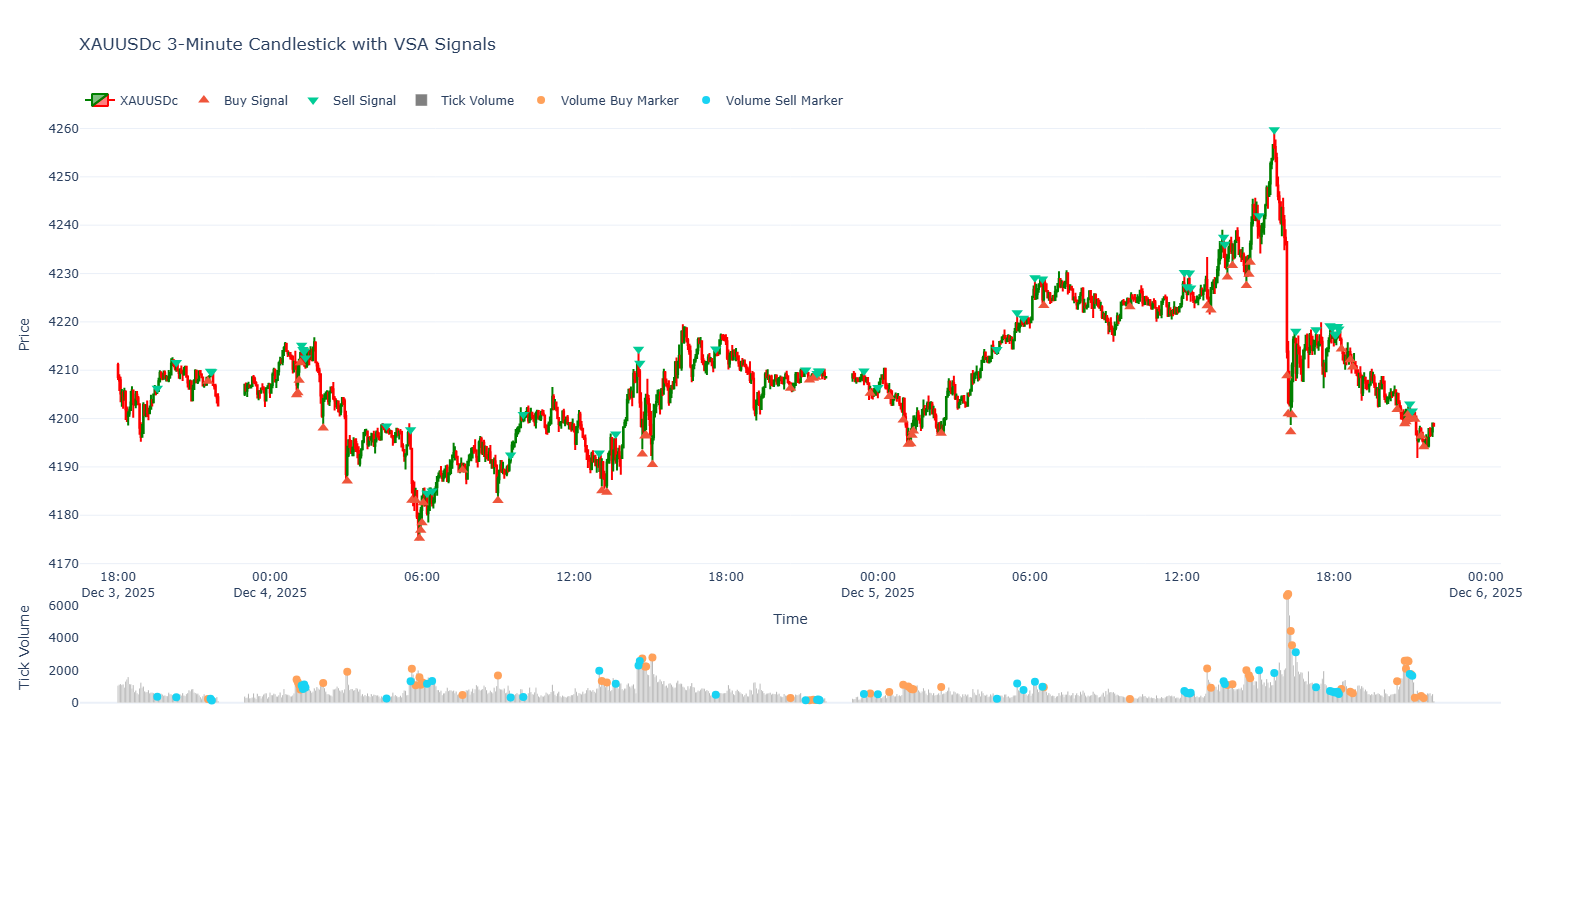

Recent VSA signals (most recent first):
2025-12-05 21:33 | Signal: BUY | Vol: 292 | Reason: No Supply (low vol narrow down bar after decline) -> probable test, buy
2025-12-05 21:27 | Signal: BUY | Vol: 418 | Reason: No Supply (low vol narrow down bar after decline) -> probable test, buy
2025-12-05 21:12 | Signal: BUY | Vol: 318 | Reason: No Supply (low vol narrow down bar after decline) -> probable test, buy
2025-12-05 21:06 | Signal: SELL | Vol: 1668 | Reason: High vol down after uptrend -> weakness (sell)
2025-12-05 21:03 | Signal: BUY | Vol: 1757 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 21:00 | Signal: SELL | Vol: 1775 | Reason: High vol down after uptrend -> weakness (sell)
2025-12-05 20:57 | Signal: BUY | Vol: 2563 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 20:54 | Signal: BUY | Vol: 2601 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 20:51 | Signal: BUY | Vol: 2104 | Reason: High vol up after downtrend -> stren

In [9]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 1000
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Feature engineering for VSA
# -------------------------
df['range'] = df['high'] - df['low']
df['body'] = (df['close'] - df['open']).abs()
df['upper_wick'] = df['high'] - df[['open', 'close']].max(axis=1)
df['lower_wick'] = df[['open', 'close']].min(axis=1) - df['low']
df['direction'] = np.where(df['close'] > df['open'], 1, np.where(df['close'] < df['open'], -1, 0))

vol_ma_len = 50
df['vol_ma'] = df['tick_volume'].rolling(vol_ma_len, min_periods=1).mean()
df['vol_std'] = df['tick_volume'].rolling(vol_ma_len, min_periods=1).std().fillna(0)
df['body_ma'] = df['body'].rolling(vol_ma_len, min_periods=1).mean()
df['range_ma'] = df['range'].rolling(vol_ma_len, min_periods=1).mean()

df['vol_z'] = (df['tick_volume'] - df['vol_ma']) / (df['vol_std'] + 1e-9)
df['body_pct'] = df['body'] / (df['range_ma'] + 1e-9)

df['close_slope'] = df['close'].diff().rolling(6, min_periods=1).mean()

# -------------------------
# 6. VSA signal logic (avoid chained assignment by using arrays)
# -------------------------
n = len(df)
signals = np.zeros(n, dtype=int)
reasons = np.full(n, '', dtype=object)

climax_multiplier = 3.0
high_vol_multiplier = 1.5
low_vol_multiplier = 0.5
small_body_thresh = 0.35
large_body_thresh = 0.6

# Use positional access via iloc to gather values, but write to arrays
for i in range(2, n):
    vol = df['tick_volume'].iat[i]
    vol_ma = df['vol_ma'].iat[i]
    direction = df['direction'].iat[i]
    body_pct = df['body_pct'].iat[i]
    upper_wick = df['upper_wick'].iat[i]
    lower_wick = df['lower_wick'].iat[i]
    close = df['close'].iat[i]
    open_ = df['open'].iat[i]
    prev_close = df['close'].iat[i-1]
    slope = df['close_slope'].iat[i-1]  # context

    # skip if vol_ma invalid
    if np.isnan(vol_ma) or vol_ma <= 0:
        continue

    # climactic volume up / down
    if vol > vol_ma * climax_multiplier:
        if direction == 1 and body_pct > large_body_thresh:
            signals[i] = -1
            reasons[i] = "Climax Up (high vol & large up bar) -> possible distribution"
            continue
        if direction == -1 and body_pct > large_body_thresh:
            signals[i] = 1
            reasons[i] = "Climax Down (high vol & large down bar) -> possible selling exhaustion"
            continue

    # high volume down after uptrend
    if vol > vol_ma * high_vol_multiplier and direction == -1 and slope > 0:
        signals[i] = -1
        reasons[i] = "High vol down after uptrend -> weakness (sell)"
        continue

    # high volume up after downtrend
    if vol > vol_ma * high_vol_multiplier and direction == 1 and slope < 0:
        signals[i] = 1
        reasons[i] = "High vol up after downtrend -> strength (buy)"
        continue

    # No Demand
    if vol < vol_ma * low_vol_multiplier and direction == 1 and body_pct < small_body_thresh and slope > 0:
        signals[i] = -1
        reasons[i] = "No Demand (low vol narrow up bar after advance) -> probable weak continuation"
        continue

    # No Supply
    if vol < vol_ma * low_vol_multiplier and direction == -1 and body_pct < small_body_thresh and slope < 0:
        signals[i] = 1
        reasons[i] = "No Supply (low vol narrow down bar after decline) -> probable test, buy"
        continue

    # Test after selling climax
    prev_vol = df['tick_volume'].iat[i-1]
    prev_dir = df['direction'].iat[i-1]
    if prev_vol > df['vol_ma'].iat[i-1] * climax_multiplier and prev_dir == -1:
        if vol < vol_ma * low_vol_multiplier and direction != -1:
            signals[i] = 1
            reasons[i] = "Test after selling climax -> buy"
            continue

# assign arrays back to df in one vectorized assignment
df['signal'] = signals
df['signal_reason'] = reasons

# -------------------------
# 7. Markers for plotting and rest of original plotting code
# -------------------------
buy_mask = df['signal'] == 1
sell_mask = df['signal'] == -1

price_buy_y = df['low'] - (df['range'] * 0.15)
price_sell_y = df['high'] + (df['range'] * 0.15)

vol_buy_y = df['tick_volume'][buy_mask]
vol_sell_y = df['tick_volume'][sell_mask]

fig = go.Figure()

fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name=symbol,
    increasing_line_color='green',
    decreasing_line_color='red'
))

fig.add_trace(go.Scatter(
    x=df.index[buy_mask],
    y=price_buy_y[buy_mask],
    mode='markers',
    marker=dict(symbol='triangle-up', size=10),
    name='Buy Signal',
    hovertext=df['signal_reason'][buy_mask],
    hoverinfo='text'
))

fig.add_trace(go.Scatter(
    x=df.index[sell_mask],
    y=price_sell_y[sell_mask],
    mode='markers',
    marker=dict(symbol='triangle-down', size=10),
    name='Sell Signal',
    hovertext=df['signal_reason'][sell_mask],
    hoverinfo='text'
))

fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

fig.add_trace(go.Scatter(
    x=df.index[buy_mask],
    y=vol_buy_y,
    mode='markers',
    marker=dict(symbol='circle', size=8),
    name='Volume Buy Marker',
    yaxis='y2',
    hovertext=df['signal_reason'][buy_mask],
    hoverinfo='text'
))
fig.add_trace(go.Scatter(
    x=df.index[sell_mask],
    y=vol_sell_y,
    mode='markers',
    marker=dict(symbol='circle', size=8),
    name='Volume Sell Marker',
    yaxis='y2',
    hovertext=df['signal_reason'][sell_mask],
    hoverinfo='text'
))

fig.update_layout(
    template='plotly_white',
    title=f'{symbol} 3-Minute Candlestick with VSA Signals',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False, anchor="x"),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()

# -------------------------
# 8. Quick signal summary
# -------------------------
recent_signals = df[df['signal'] != 0].copy().tail(20)
if not recent_signals.empty:
    print("Recent VSA signals (most recent first):")
    for idx, row in recent_signals[::-1].iterrows():
        ts = idx.strftime("%Y-%m-%d %H:%M")
        print(f"{ts} | Signal: {'BUY' if row['signal']==1 else 'SELL'} | Vol: {int(row['tick_volume'])} | Reason: {row['signal_reason']}")
else:
    print("No VSA signals found in the dataset.")


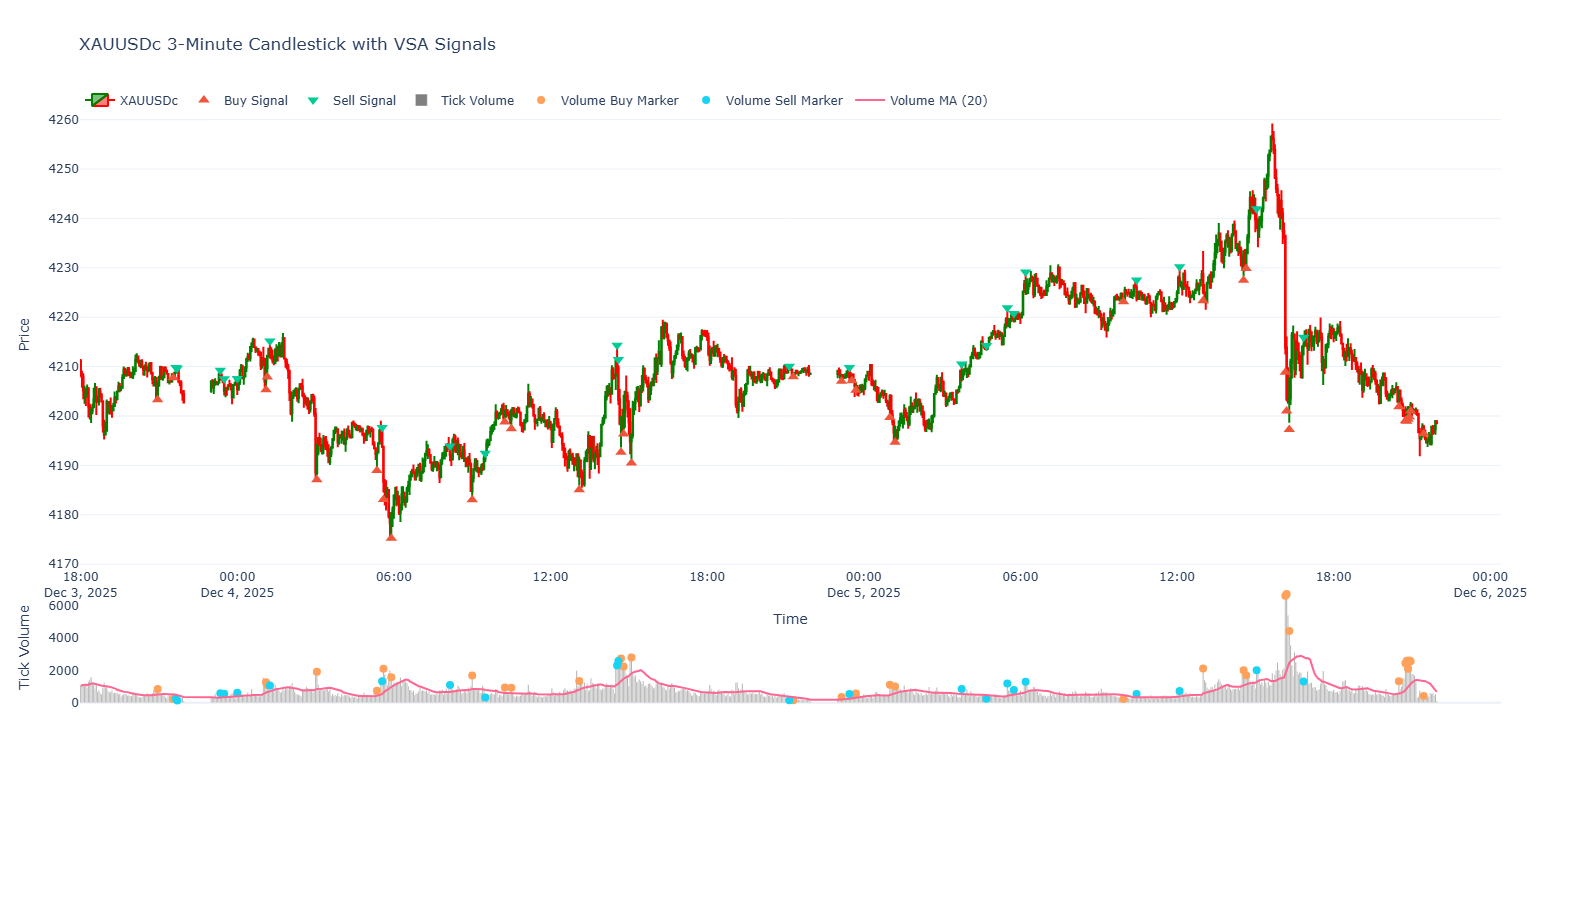

Recent VSA signals (most recent first):
2025-12-05 21:27 | Signal: BUY | Vol: 418 | Reason: No Supply (low vol narrow down bar after decline) -> probable test, buy
2025-12-05 20:57 | Signal: BUY | Vol: 2563 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 20:54 | Signal: BUY | Vol: 2601 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 20:51 | Signal: BUY | Vol: 2104 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 20:48 | Signal: BUY | Vol: 2596 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 20:45 | Signal: BUY | Vol: 2435 | Reason: Climax Down (high vol & large down bar) -> possible selling exhaustion
2025-12-05 20:30 | Signal: BUY | Vol: 1332 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 16:51 | Signal: SELL | Vol: 1316 | Reason: No Demand (low vol narrow up bar after advance) -> probable weak continuation
2025-12-05 16:18 | Signal: BUY | Vol: 4421 | Reason: High vol up after downtrend -> s

In [16]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 1000
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Feature engineering for VSA
# -------------------------
df['range'] = df['high'] - df['low']
df['body'] = (df['close'] - df['open']).abs()
df['upper_wick'] = df['high'] - df[['open', 'close']].max(axis=1)
df['lower_wick'] = df[['open', 'close']].min(axis=1) - df['low']
df['direction'] = np.where(df['close'] > df['open'], 1, np.where(df['close'] < df['open'], -1, 0))

vol_ma_len = 20
df['vol_ma'] = df['tick_volume'].rolling(vol_ma_len, min_periods=1).mean()
df['vol_std'] = df['tick_volume'].rolling(vol_ma_len, min_periods=1).std().fillna(0)
df['body_ma'] = df['body'].rolling(vol_ma_len, min_periods=1).mean()
df['range_ma'] = df['range'].rolling(vol_ma_len, min_periods=1).mean()

df['vol_z'] = (df['tick_volume'] - df['vol_ma']) / (df['vol_std'] + 1e-9)
df['body_pct'] = df['body'] / (df['range_ma'] + 1e-9)

df['close_slope'] = df['close'].diff().rolling(6, min_periods=1).mean()

# -------------------------
# 6. VSA signal logic
# -------------------------
n = len(df)
signals = np.zeros(n, dtype=int)
reasons = np.full(n, '', dtype=object)

climax_multiplier = 3.0
high_vol_multiplier = 1.5
low_vol_multiplier = 0.5
small_body_thresh = 0.35
large_body_thresh = 0.6

for i in range(2, n):
    vol = df['tick_volume'].iat[i]
    vol_ma = df['vol_ma'].iat[i]
    direction = df['direction'].iat[i]
    body_pct = df['body_pct'].iat[i]
    upper_wick = df['upper_wick'].iat[i]
    lower_wick = df['lower_wick'].iat[i]
    close = df['close'].iat[i]
    open_ = df['open'].iat[i]
    prev_close = df['close'].iat[i-1]
    slope = df['close_slope'].iat[i-1]

    if np.isnan(vol_ma) or vol_ma <= 0:
        continue

    if vol > vol_ma * climax_multiplier:
        if direction == 1 and body_pct > large_body_thresh:
            signals[i] = -1
            reasons[i] = "Climax Up (high vol & large up bar) -> possible distribution"
            continue
        if direction == -1 and body_pct > large_body_thresh:
            signals[i] = 1
            reasons[i] = "Climax Down (high vol & large down bar) -> possible selling exhaustion"
            continue

    if vol > vol_ma * high_vol_multiplier and direction == -1 and slope > 0:
        signals[i] = -1
        reasons[i] = "High vol down after uptrend -> weakness (sell)"
        continue

    if vol > vol_ma * high_vol_multiplier and direction == 1 and slope < 0:
        signals[i] = 1
        reasons[i] = "High vol up after downtrend -> strength (buy)"
        continue

    if vol < vol_ma * low_vol_multiplier and direction == 1 and body_pct < small_body_thresh and slope > 0:
        signals[i] = -1
        reasons[i] = "No Demand (low vol narrow up bar after advance) -> probable weak continuation"
        continue

    if vol < vol_ma * low_vol_multiplier and direction == -1 and body_pct < small_body_thresh and slope < 0:
        signals[i] = 1
        reasons[i] = "No Supply (low vol narrow down bar after decline) -> probable test, buy"
        continue

    prev_vol = df['tick_volume'].iat[i-1]
    prev_dir = df['direction'].iat[i-1]
    if prev_vol > df['vol_ma'].iat[i-1] * climax_multiplier and prev_dir == -1:
        if vol < vol_ma * low_vol_multiplier and direction != -1:
            signals[i] = 1
            reasons[i] = "Test after selling climax -> buy"
            continue

df['signal'] = signals
df['signal_reason'] = reasons

# -------------------------
# 7. Plotting (with VOLUME MA added)
# -------------------------
buy_mask = df['signal'] == 1
sell_mask = df['signal'] == -1

price_buy_y = df['low'] - (df['range'] * 0.15)
price_sell_y = df['high'] + (df['range'] * 0.15)

vol_buy_y = df['tick_volume'][buy_mask]
vol_sell_y = df['tick_volume'][sell_mask]

fig = go.Figure()

fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name=symbol,
    increasing_line_color='green',
    decreasing_line_color='red'
))

fig.add_trace(go.Scatter(
    x=df.index[buy_mask],
    y=price_buy_y[buy_mask],
    mode='markers',
    marker=dict(symbol='triangle-up', size=10),
    name='Buy Signal',
    hovertext=df['signal_reason'][buy_mask],
    hoverinfo='text'
))

fig.add_trace(go.Scatter(
    x=df.index[sell_mask],
    y=price_sell_y[sell_mask],
    mode='markers',
    marker=dict(symbol='triangle-down', size=10),
    name='Sell Signal',
    hovertext=df['signal_reason'][sell_mask],
    hoverinfo='text'
))

fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

fig.add_trace(go.Scatter(
    x=df.index[buy_mask],
    y=vol_buy_y,
    mode='markers',
    marker=dict(symbol='circle', size=8),
    name='Volume Buy Marker',
    yaxis='y2',
    hovertext=df['signal_reason'][buy_mask],
    hoverinfo='text'
))
fig.add_trace(go.Scatter(
    x=df.index[sell_mask],
    y=vol_sell_y,
    mode='markers',
    marker=dict(symbol='circle', size=8),
    name='Volume Sell Marker',
    yaxis='y2',
    hovertext=df['signal_reason'][sell_mask],
    hoverinfo='text'
))

# -------------------------
# NEW: Volume Moving Average Plot
# -------------------------
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['vol_ma'],
    mode='lines',
    line=dict(width=2),
    name=f'Volume MA ({vol_ma_len})',
    yaxis='y2'
))

fig.update_layout(
    template='plotly_white',
    title=f'{symbol} 3-Minute Candlestick with VSA Signals',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False, anchor="x"),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()

# -------------------------
# 8. Quick signal summary
# -------------------------
recent_signals = df[df['signal'] != 0].copy().tail(20)
if not recent_signals.empty:
    print("Recent VSA signals (most recent first):")
    for idx, row in recent_signals[::-1].iterrows():
        ts = idx.strftime("%Y-%m-%d %H:%M")
        print(f"{ts} | Signal: {'BUY' if row['signal']==1 else 'SELL'} | Vol: {int(row['tick_volume'])} | Reason: {row['signal_reason']}")
else:
    print("No VSA signals found in the dataset.")


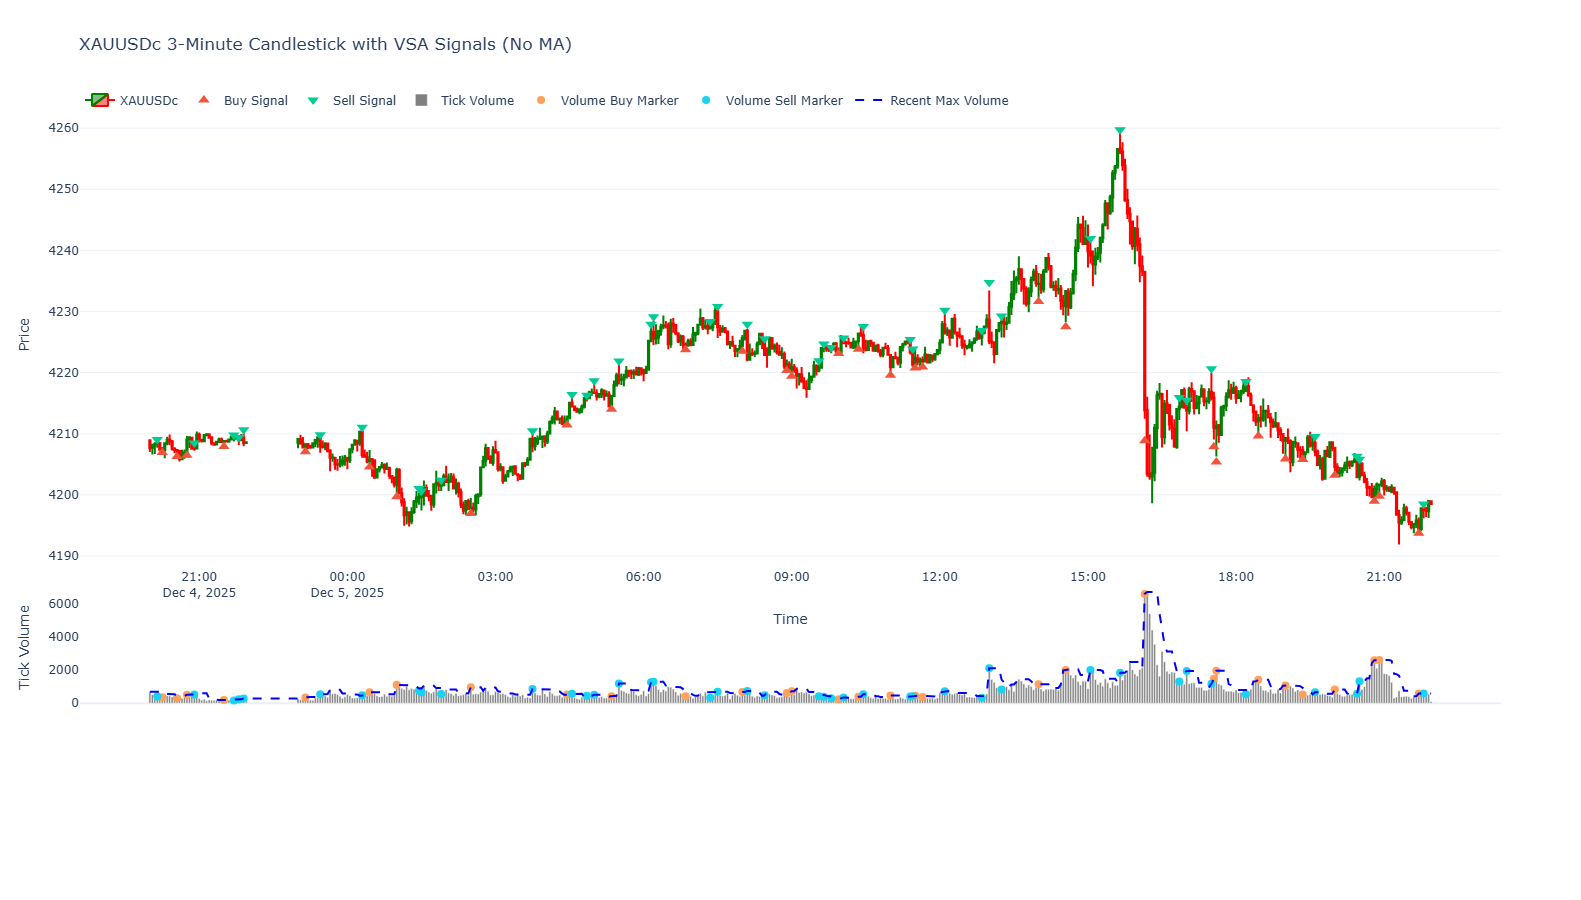

Recent VSA signals (most recent first):
2025-12-05 21:48 | Signal: SELL | Vol: 595 | Reason: High vol down after uptrend -> weakness (sell)
2025-12-05 21:42 | Signal: BUY | Vol: 588 | Reason: Climax Down (high vol & large down bar) -> possible selling exhaustion
2025-12-05 20:54 | Signal: BUY | Vol: 2601 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 20:48 | Signal: BUY | Vol: 2596 | Reason: High vol up after downtrend -> strength (buy)
2025-12-05 20:30 | Signal: SELL | Vol: 1332 | Reason: Climax Up (high vol & large up bar) -> possible distribution
2025-12-05 20:27 | Signal: SELL | Vol: 566 | Reason: High vol down after uptrend -> weakness (sell)
2025-12-05 20:00 | Signal: BUY | Vol: 836 | Reason: Climax Down (high vol & large down bar) -> possible selling exhaustion
2025-12-05 19:36 | Signal: SELL | Vol: 669 | Reason: High vol down after uptrend -> weakness (sell)
2025-12-05 19:21 | Signal: BUY | Vol: 524 | Reason: No Supply (low vol narrow down bar after decline)

In [21]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# 1. Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# 2. Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=3)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# 3. Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)

# -------------------------
# 4. Remove non-trading periods (weekends)
# -------------------------
df = df[df.index.dayofweek < 5]

# -------------------------
# 5. Feature engineering for VSA
# -------------------------
df['range'] = df['high'] - df['low']
df['body'] = (df['close'] - df['open']).abs()
df['upper_wick'] = df['high'] - df[['open', 'close']].max(axis=1)
df['lower_wick'] = df[['open', 'close']].min(axis=1) - df['low']
df['direction'] = np.where(df['close'] > df['open'], 1, np.where(df['close'] < df['open'], -1, 0))

# Contextual rolling lookback (for relative volume, slopes, trend)
lookback_vol = 5
lookback_slope = 6

df['vol_max_recent'] = df['tick_volume'].rolling(lookback_vol, min_periods=1).max()
df['vol_min_recent'] = df['tick_volume'].rolling(lookback_vol, min_periods=1).min()
df['close_slope'] = df['close'].diff().rolling(lookback_slope, min_periods=1).mean()

df['body_pct'] = df['body'] / (df['range'] + 1e-9)  # normalized body size

# -------------------------
# 6. VSA signal logic (no moving averages)
# -------------------------
n = len(df)
signals = np.zeros(n, dtype=int)
reasons = np.full(n, '', dtype=object)

climax_multiplier = 1.2
high_vol_multiplier = 1.0
low_vol_multiplier = 1.0
small_body_thresh = 0.35
large_body_thresh = 0.6

for i in range(2, n):
    vol = df['tick_volume'].iat[i]
    max_vol = df['vol_max_recent'].iat[i-1]
    min_vol = df['vol_min_recent'].iat[i-1]
    direction = df['direction'].iat[i]
    body_pct = df['body_pct'].iat[i]
    slope = df['close_slope'].iat[i-1]

    # Climax bars
    if vol > max_vol * climax_multiplier:
        if direction == 1 and body_pct > large_body_thresh:
            signals[i] = -1
            reasons[i] = "Climax Up (high vol & large up bar) -> possible distribution"
            continue
        if direction == -1 and body_pct > large_body_thresh:
            signals[i] = 1
            reasons[i] = "Climax Down (high vol & large down bar) -> possible selling exhaustion"
            continue

    # High volume after trend
    if vol > max_vol * high_vol_multiplier:
        if direction == -1 and slope > 0:
            signals[i] = -1
            reasons[i] = "High vol down after uptrend -> weakness (sell)"
            continue
        if direction == 1 and slope < 0:
            signals[i] = 1
            reasons[i] = "High vol up after downtrend -> strength (buy)"
            continue

    # Low volume tests
    if vol < min_vol * low_vol_multiplier:
        if direction == 1 and body_pct < small_body_thresh and slope > 0:
            signals[i] = -1
            reasons[i] = "No Demand (low vol narrow up bar after advance) -> probable weak continuation"
            continue
        if direction == -1 and body_pct < small_body_thresh and slope < 0:
            signals[i] = 1
            reasons[i] = "No Supply (low vol narrow down bar after decline) -> probable test, buy"
            continue

    # Test after selling climax
    prev_vol = df['tick_volume'].iat[i-1]
    prev_dir = df['direction'].iat[i-1]
    prev_max_vol = df['vol_max_recent'].iat[i-1]
    if prev_vol > prev_max_vol * climax_multiplier and prev_dir == -1:
        if vol < min_vol * low_vol_multiplier and direction != -1:
            signals[i] = 1
            reasons[i] = "Test after selling climax -> buy"
            continue

df['signal'] = signals
df['signal_reason'] = reasons

# -------------------------
# 7. Plotting (price + volume + signals)
# -------------------------
buy_mask = df['signal'] == 1
sell_mask = df['signal'] == -1

price_buy_y = df['low'] - (df['range'] * 0.15)
price_sell_y = df['high'] + (df['range'] * 0.15)

vol_buy_y = df['tick_volume'][buy_mask]
vol_sell_y = df['tick_volume'][sell_mask]

fig = go.Figure()

# Candlestick
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name=symbol,
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Buy/Sell markers on price
fig.add_trace(go.Scatter(
    x=df.index[buy_mask],
    y=price_buy_y[buy_mask],
    mode='markers',
    marker=dict(symbol='triangle-up', size=10),
    name='Buy Signal',
    hovertext=df['signal_reason'][buy_mask],
    hoverinfo='text'
))
fig.add_trace(go.Scatter(
    x=df.index[sell_mask],
    y=price_sell_y[sell_mask],
    mode='markers',
    marker=dict(symbol='triangle-down', size=10),
    name='Sell Signal',
    hovertext=df['signal_reason'][sell_mask],
    hoverinfo='text'
))

# Tick Volume
fig.add_trace(go.Bar(
    x=df.index,
    y=df['tick_volume'],
    name='Tick Volume',
    marker_color='gray',
    yaxis='y2'
))

# Volume markers
fig.add_trace(go.Scatter(
    x=df.index[buy_mask],
    y=vol_buy_y,
    mode='markers',
    marker=dict(symbol='circle', size=8),
    name='Volume Buy Marker',
    yaxis='y2',
    hovertext=df['signal_reason'][buy_mask],
    hoverinfo='text'
))
fig.add_trace(go.Scatter(
    x=df.index[sell_mask],
    y=vol_sell_y,
    mode='markers',
    marker=dict(symbol='circle', size=8),
    name='Volume Sell Marker',
    yaxis='y2',
    hovertext=df['signal_reason'][sell_mask],
    hoverinfo='text'
))

# Optional: recent maximum volume line for visual reference
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['vol_max_recent'],
    mode='lines',
    line=dict(width=2, dash='dash', color='blue'),
    name=f'Recent Max Volume',
    yaxis='y2'
))

fig.update_layout(
    template='plotly_white',
    title=f'{symbol} 3-Minute Candlestick with VSA Signals (No MA)',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),
    yaxis=dict(title='Price', domain=[0.35, 1]),
    yaxis2=dict(title='Tick Volume', domain=[0.15, 0.33], showgrid=False, anchor="x"),
    legend=dict(orientation='h', y=1.02, x=0),
    height=900
)

fig.show()

# -------------------------
# 8. Quick signal summary
# -------------------------
recent_signals = df[df['signal'] != 0].copy().tail(20)
if not recent_signals.empty:
    print("Recent VSA signals (most recent first):")
    for idx, row in recent_signals[::-1].iterrows():
        ts = idx.strftime("%Y-%m-%d %H:%M")
        print(f"{ts} | Signal: {'BUY' if row['signal']==1 else 'SELL'} | Vol: {int(row['tick_volume'])} | Reason: {row['signal_reason']}")
else:
    print("No VSA signals found in the dataset.")
